In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-03-31 15:08:38--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-03-31 15:08:38 (7.96 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates = True)
df.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [4]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month'>

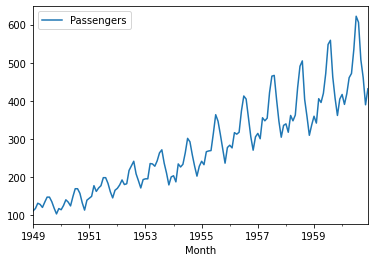

In [6]:
df.plot()

In [7]:
alpha = 0.2

In [16]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha,adjust = False).mean()

In [19]:
type(df['Passengers'].ewm(alpha=alpha,adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

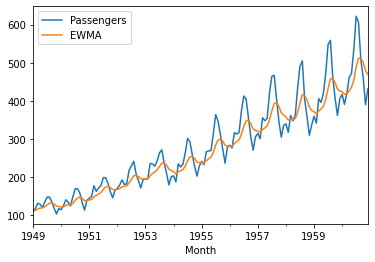

In [21]:
df.plot();

In [22]:
df


,Passengers,EWMA
Month,,
1949-01-01,112,112.000000
1949-02-01,118,113.200000
1949-03-01,132,116.960000
1949-04-01,129,119.368000
1949-05-01,121,119.694400
...,...,...
1960-08-01,606,512.214093
1960-09-01,508,511.371274
1960-10-01,461,501.297019


In [24]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma)>0:
        xhat=alpha*x+(1-alpha)*manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual_EWMA'] = manual_ewma

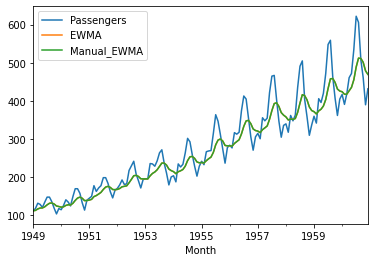

In [27]:
df.plot();

In [29]:
df.head()

,Passengers,EWMA,Manual_EWMA
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [30]:
df.drop('Manual_EWMA',axis=1,inplace = True)

In [31]:
df

,Passengers,EWMA
Month,,
1949-01-01,112,112.000000
1949-02-01,118,113.200000
1949-03-01,132,116.960000
1949-04-01,129,119.368000
1949-05-01,121,119.694400
...,...,...
1960-08-01,606,512.214093
1960-09-01,508,511.371274
1960-10-01,461,501.297019


In [32]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [39]:
ses = SimpleExpSmoothing(df['Passengers'])

In [37]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [38]:
df.index.freq='MS'

In [40]:
res = ses.fit(smoothing_level=alpha,optimized=False)

In [41]:
res

In [42]:
res.predict(start = df.index[0],end = df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [43]:
df['SES'] = res.predict(start = df.index[0],end = df.index[-1])

In [47]:
np.allclose(df['SES'],res.fittedvalues)

True

<AxesSubplot:xlabel='Month'>

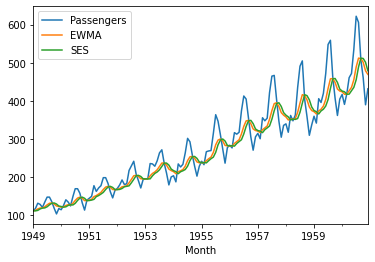

In [48]:
df.plot()

In [49]:
df['SES-1'] = df['SES'].shift(-1)

In [50]:
df

,Passengers,EWMA,SES,SES-1
Month,,,,
1949-01-01,112,112.000000,112.000000,112.000000
1949-02-01,118,113.200000,112.000000,113.200000
1949-03-01,132,116.960000,113.200000,116.960000
1949-04-01,129,119.368000,116.960000,119.368000
1949-05-01,121,119.694400,119.368000,119.694400
...,...,...,...,...
1960-08-01,606,512.214093,488.767616,512.214093
1960-09-01,508,511.371274,512.214093,511.371274
1960-10-01,461,501.297019,511.371274,501.297019


In [68]:
#Split our dataset 
N_test = 12
#Train is everything up to last 12 elements
train = df.iloc[:-N_test]
test = df.iloc[-N_test:] #last 12 datapoints

In [69]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<ipython-input-70-a14251fe2b32>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test,'SESfitted'] = res.fittedvalues
<ipython-input-70-a14251fe2b32>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:,'SESfitted'] = res.forecast(N_test)


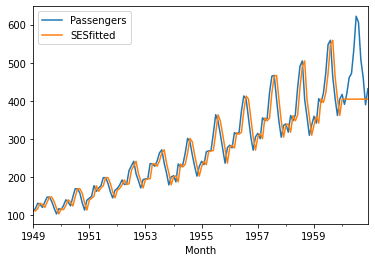

In [70]:
df.loc[:-N_test,'SESfitted'] = res.fittedvalues
df.loc[-N_test:,'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot();

In [72]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [75]:
from statsmodels.tsa.holtwinters import Holt

In [76]:
holt = Holt(df['Passengers'])

/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [77]:
res_h = holt.fit()

In [79]:
df['Holt'] = res_h.fittedvalues

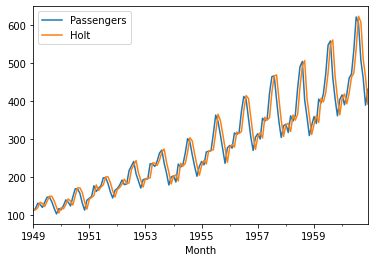

In [80]:
df[['Passengers','Holt']].plot();

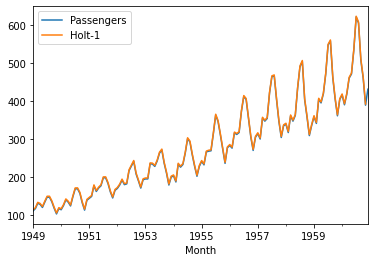

In [83]:
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers','Holt-1']].plot();

In [85]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test,'Holt'] = res_h.fittedvalues

/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-85-9f871831f421>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test,'Holt'] = res_h.fittedvalues


In [86]:
df.loc[-N_test:,'Holt'] = res_h.forecast(N_test)

<ipython-input-86-fb7c28ef89d9>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:,'Holt'] = res_h.forecast(N_test)


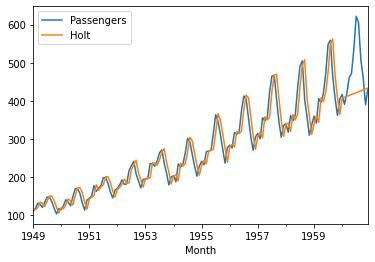

In [87]:
df[['Passengers','Holt']].plot();

In [90]:
 from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [91]:
hw = ExponentialSmoothing(train['Passengers'],\
                          trend = 'add',seasonal='add',seasonal_periods=12)
res_hw = hw.fit()

/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [97]:
df.loc[:-N_test,'HoltWinters']  = res_hw.fittedvalues

<ipython-input-97-7dee23ceb654>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test,'HoltWinters']  = res_hw.fittedvalues


In [107]:
df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)

<ipython-input-107-aac6f836c875>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)


<AxesSubplot:xlabel='Month'>

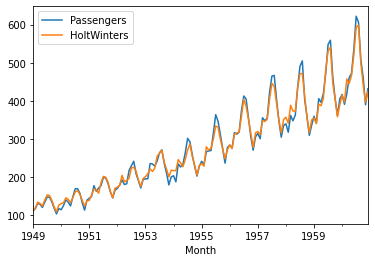

In [108]:
df[['Passengers','HoltWinters']].plot()

In [111]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))

In [112]:
def mae(y,t):
    return np.mean(np.abs(y-t))

In [113]:
print("Train RMSE: ", rmse(train['Passengers'],res_hw.fittedvalues))
print('Test RMSE: ',rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  11.624689715996467
Test RMSE:  16.979214338898583


In [114]:
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print('Test MAE: ',mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  9.008004651784935
Test MAE:  13.37945869273041


/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-123-25afc0c9df74>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test,'HoltWinters'] = res_hw.fittedvalues
<ipython-input-123-25afc0c9df74>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)


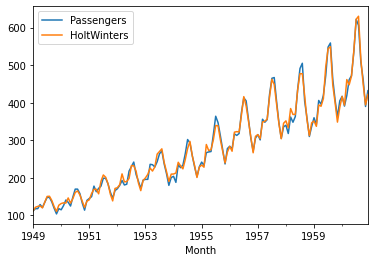

In [123]:

hw = ExponentialSmoothing(train['Passengers'],\
                          trend='add',seasonal='mul',
                          seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test,'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot();

In [124]:
print("Train RMSE: ", rmse(train['Passengers'],res_hw.fittedvalues))
print('Test RMSE: ',rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  9.931187473565274
Test RMSE:  15.536855932715705


In [125]:
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print('Test MAE: ',mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  7.828398575656024
Test MAE:  10.023341762702117


/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/vadimsmirnov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-126-4f55c06baba9>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test,'HoltWinters'] = res_hw.fittedvalues
<ipython-input-126-4f55c06baba9>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)


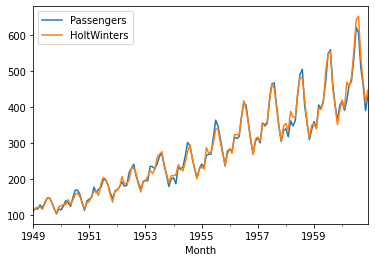

In [126]:
df
hw = ExponentialSmoothing(train['Passengers'],\
                          trend='mul',seasonal='mul',
                          seasonal_periods=12)
res_hw = hw.fit()
df.loc[:-N_test,'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:,'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot();

In [127]:
print("Train RMSE: ", rmse(train['Passengers'],res_hw.fittedvalues))
print('Test RMSE: ',rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  9.79774217179129
Test RMSE:  24.442675830287346


In [128]:
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print('Test MAE: ',mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  7.426138802213457
Test MAE:  19.510581833385057
